In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from tqdm import tqdm

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv(dotenv_path='env_var.env')

True

# Tabular Attributes

## Load Data

In [2]:
train_path = os.getenv('TRAIN_DATASET_PATH')
test_path = os.getenv('TEST_DATASET_PATH')

try:
    train_dataset = pd.read_csv(train_path)
    test_dataset = pd.read_csv(test_path)
except Exception as e:
    print(f"Error loading data: {e}")

##  Overview of Train/Test Datasets

In [3]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


In [4]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  363835 non-null  int64  
 1   goods_depersanalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB


In [5]:
train_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586


In [6]:
test_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235


In [7]:
print(f"Trainset Rows/Columns: {train_dataset.shape}")
print(f"Testset Rows/Columns: {test_dataset.shape}")
print(f"Trainset Target Balance: {sum(train_dataset['target'])/train_dataset.shape[0]}")
print(f"Target Values Distribution:\n{train_dataset['target'].value_counts()}")

Trainset Rows/Columns: (2518441, 9)
Testset Rows/Columns: (363835, 8)
Trainset Target Balance: 0.11699420395395406
Target Values Distribution:
target
0    2223798
1     294643
Name: count, dtype: int64


### Conclusion: Dataset Overview

- The **training dataset** consists of **2,518,441** samples with **9 columns**, while the **test dataset** contains **363,835** samples with **8 columns** (excluding the target variable).
- There is a **significant class imbalance**:
  - **Positive class (`target = 1`)**: 11.7%
  - **Negative class (`target = 0`)**: 88.3%
- Because of this imbalance, **accuracy is not a reliable performance metric**.
  - A model predicting only the majority class would appear accurate, but would fail to capture meaningful patterns.
  - Instead, the **F1 score** is preferred, as it provides a better balance between **precision** and **recall**.
- Some columns, such as `goods_price`, contain **missing values** that should be handled during preprocessing to ensure model robustness.


## Data Preprocessing

### Missing Values

In [8]:
# A function to estimate missing values
def gaps(df):
    try:
        (df.isna().mean() * 100)\
        .to_frame()\
        .rename(columns={0: 'Missing %'})\
        .query('`Missing %` > 0')\
        .sort_values(by='Missing %', ascending=True)\
        .plot(kind='barh', figsize=(12, 8), rot=0, legend=False, fontsize=14, color='skyblue', edgecolor='black')\
        .set_title('Missing Values Percentage by Column\n', fontsize=20, fontweight='bold', color='SteelBlue')
 
        plt.xlabel('Missing Values Percentage (%)', fontsize=14, fontweight='bold')
        plt.ylabel('Columns', fontsize=14, fontweight='bold')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()  
        plt.show()

    except:
        print('No gaps left  :)')


#### `train_dataset`

##### Checking missing values

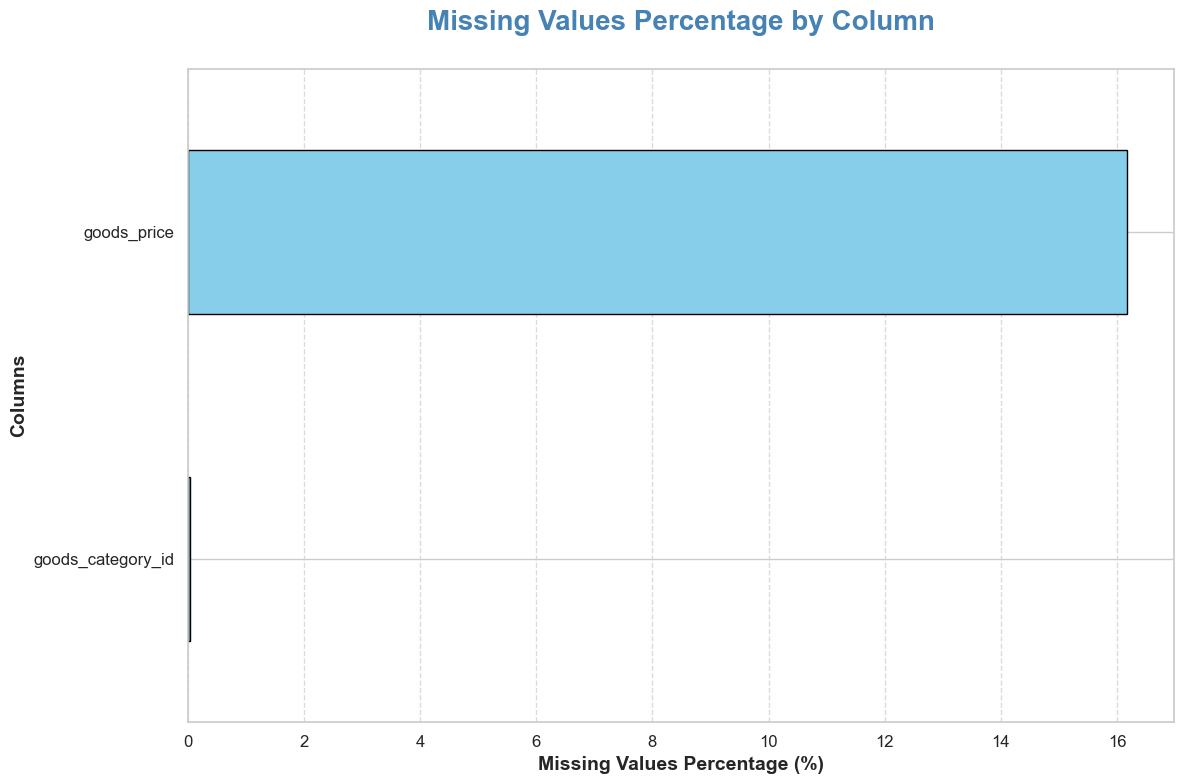

In [9]:
gaps(train_dataset)

Approximately 16% of values are missing in the `goods_price` field, with a minimal percentage missing in the `goods_category_id` field. Let's examine how these missing values can be handled.

##### Analysis of the distribution of values in the `goods_category_id` column to determine the most appropriate method for imputing missing values:

**Creating functions for plotting distributions**

In [10]:
def plot_distribution(dataset, column, title):
    """ 
    Plots the distribution of a specified column in the given dataset.
    
    Parameters:
        dataset (DataFrame)
        column (str)
        title (str)
    """
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=16, y=1.03, fontweight='bold')
    dataset[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Categories', fontsize=14, labelpad=10, fontweight='bold')
    plt.ylabel('Count', fontsize=14, labelpad=10, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_price_by_category(dataset, column, value, title):
    """
    Plots the median values of a specified column grouped by categories.
    
    Parameters:
        dataset (DataFrame)
        column (str)
        value (str)
        title (str)
    """
    # Calculate median by category
    category_medians = dataset.groupby(column)[value].median()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=16, y=1.03, fontweight='bold')
    category_medians.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Categories', fontsize=14, labelpad=10, fontweight='bold')
    plt.ylabel('Median Value', fontsize=14, labelpad=10, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


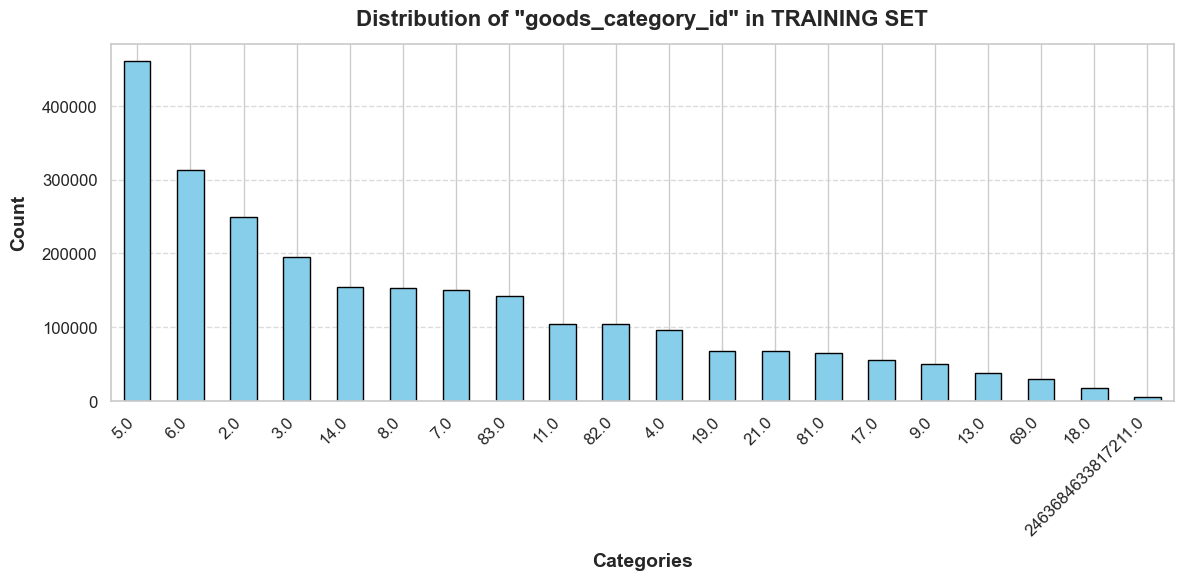

In [11]:
plot_distribution(train_dataset, 'goods_category_id', 'Distribution of "goods_category_id" in TRAINING SET')

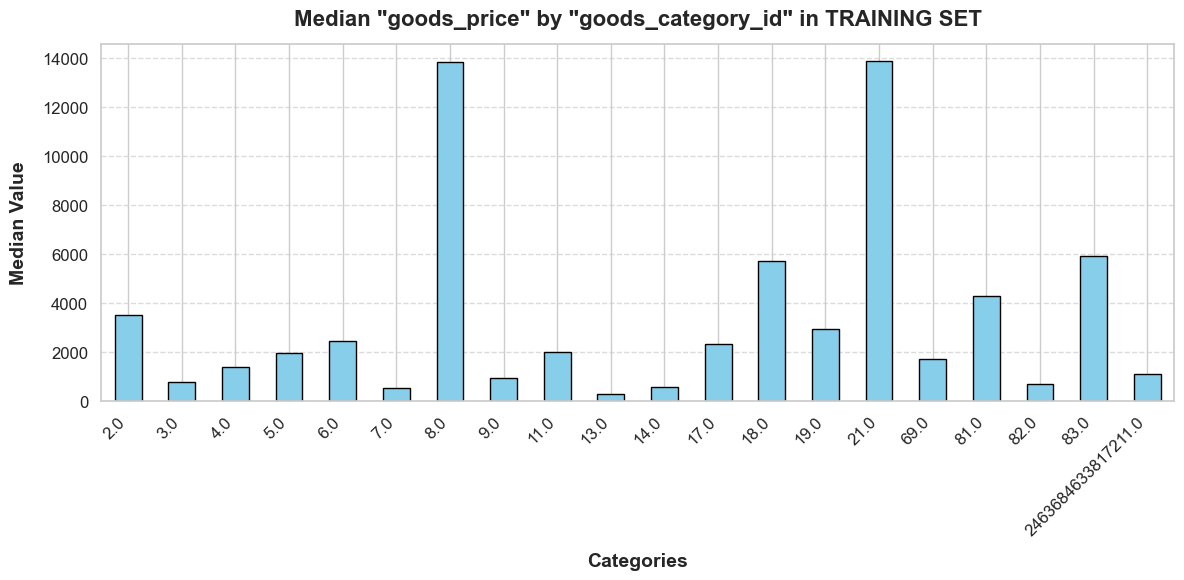

In [12]:
plot_price_by_category(train_dataset, 
                       'goods_category_id', 
                       'goods_price', 
                       'Median "goods_price" by "goods_category_id" in TRAINING SET')

The missing values in the `goods_category_id` column will be filled with a placeholder value of `99`. This approach is chosen to avoid introducing any bias or misclassification from the existing categories (such as 5.0, 82.0, 18.0, 4.0, 7.0, etc), while still ensuring that the missing data can be processed effectively for downstream tasks. One-hot encoding will be applied to the data later, which will allow the model to handle the placeholder value appropriately as a distinct category.

In [13]:
train_dataset['goods_category_id'] = train_dataset['goods_category_id'].fillna(99.0)

The missing values in the `goods_price` column will be filled using the median price for each category. This approach ensures that the imputed values are consistent with the price distribution within their respective categories, preserving the structure of the data. The median is chosen for its robustness to outliers, which helps avoid distortion from extreme values when filling the gaps.

By imputing missing values based on category-specific medians, the approach maintains the integrity of each product category's price distribution. This method prevents the introduction of arbitrary values, which could introduce bias, and ensures the data remains consistent for downstream analysis and modeling.

In [14]:
for c in train_dataset['goods_category_id'].unique():
    train_dataset.loc[(train_dataset['goods_category_id'] == c) & (train_dataset['goods_price'].isna()), 'goods_price'] = \
    train_dataset.loc[(train_dataset['goods_category_id'] == c), 'goods_price'].median()

##### Ensuring no missing values are left

No gaps left  :)


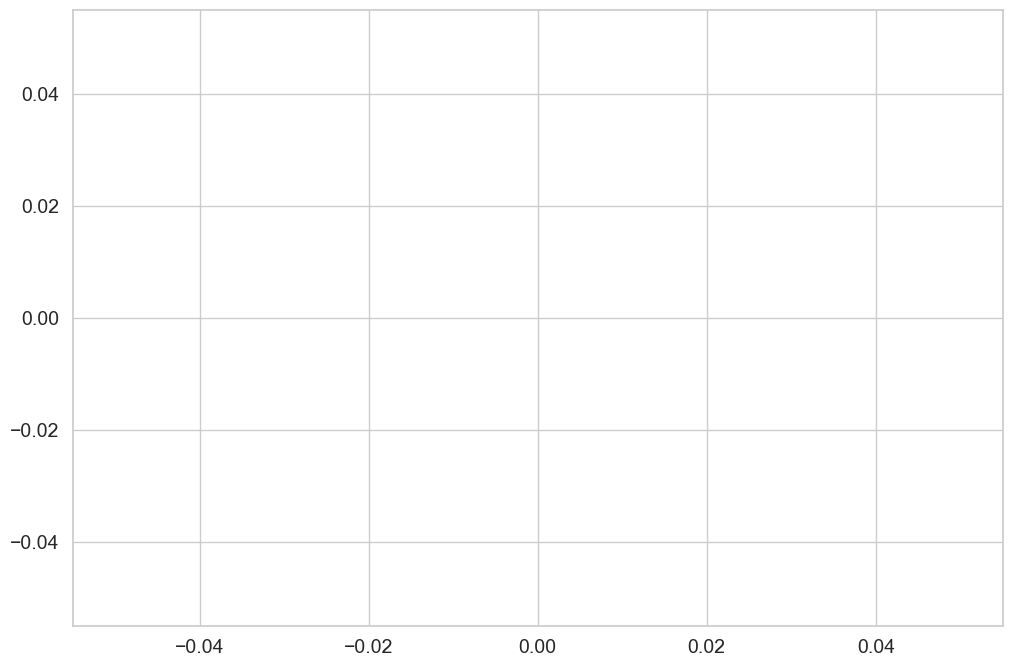

In [15]:
gaps(train_dataset)

#### `test_dataset`

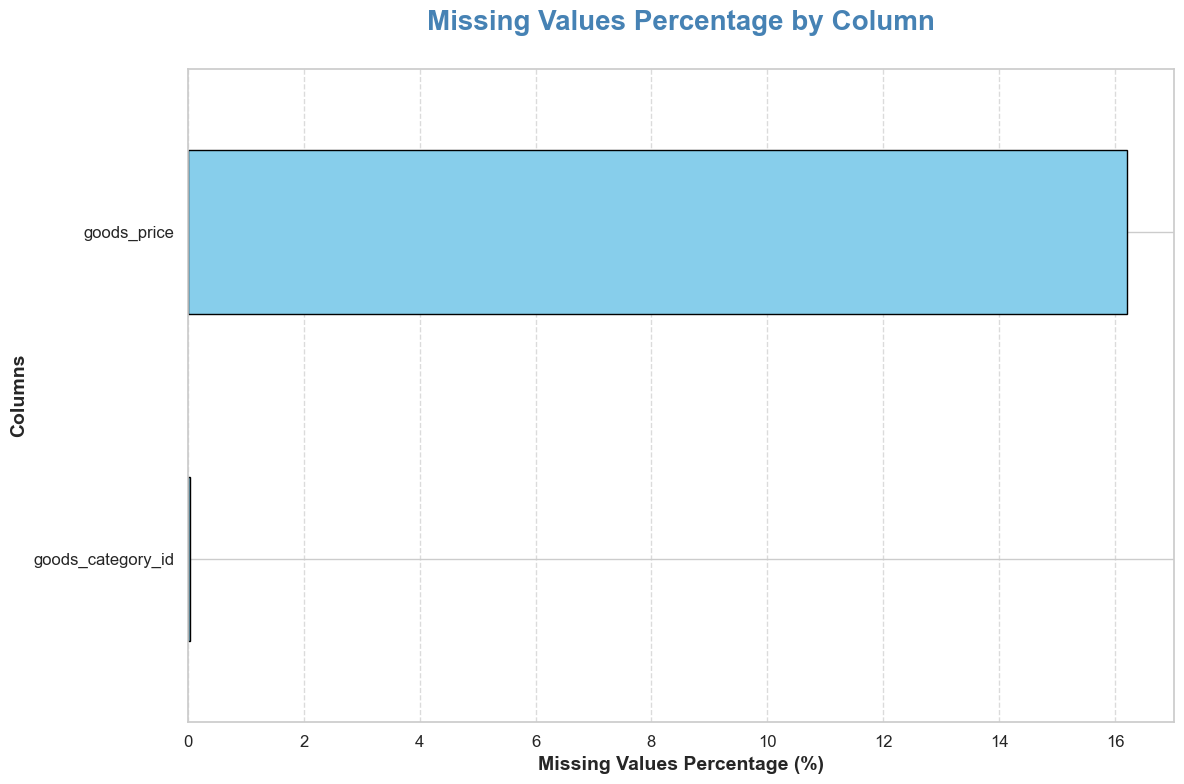

In [16]:
gaps(test_dataset)

Result similar to `train_dataset`

##### Analysis of the distribution of values in the `goods_category_id` column to determine the most appropriate method for imputing missing values:

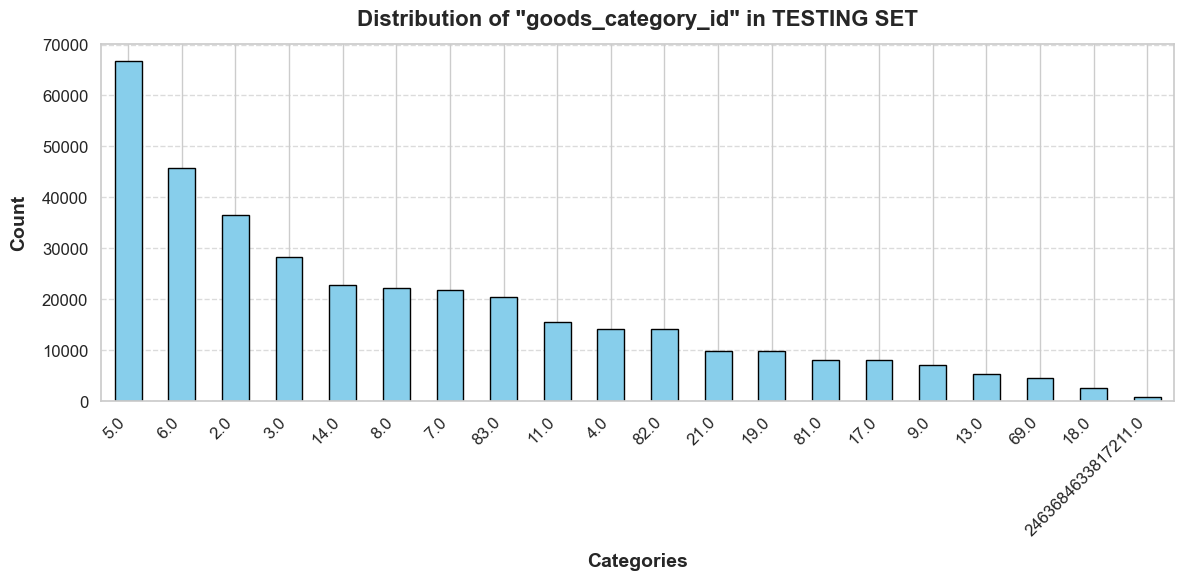

In [17]:
plot_distribution(test_dataset, 'goods_category_id', 'Distribution of "goods_category_id" in TESTING SET')

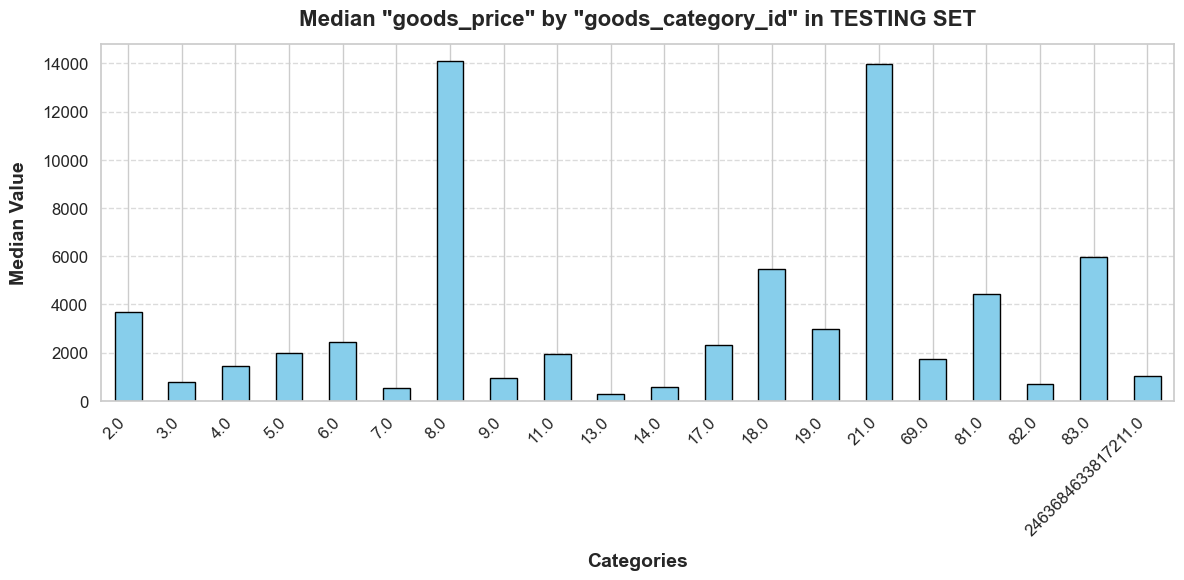

In [18]:
plot_price_by_category(test_dataset, 
                       'goods_category_id', 
                       'goods_price', 
                       'Median "goods_price" by "goods_category_id" in TESTING SET')

Given that the conditions are identical to those in the `train_dataset`, the same imputation strategy will be applied to handle the missing values:

In [19]:
# filling gaps in "goods_category_id"
test_dataset['goods_category_id'] = test_dataset['goods_category_id'].fillna(99.0)
# filling gaps in "goods_price"
for c in test_dataset['goods_category_id'].unique():
    test_dataset.loc[(test_dataset['goods_category_id'] == c) & (test_dataset['goods_price'].isna()), 'goods_price'] = \
    test_dataset.loc[(test_dataset['goods_category_id'] == c), 'goods_price'].median()

##### Ensuring no missing values are left

No gaps left  :)


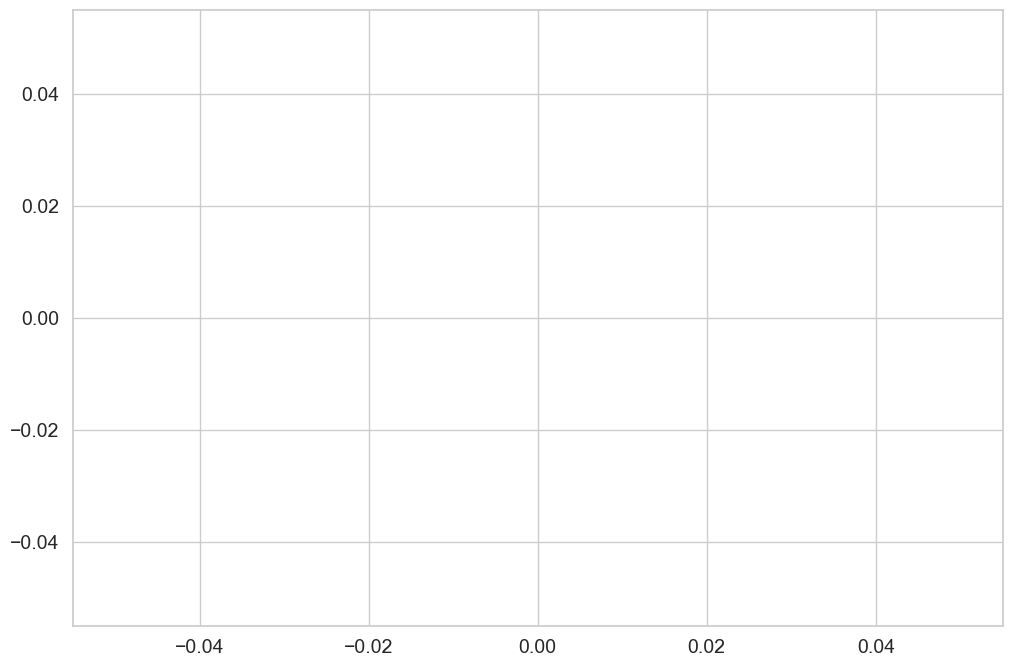

In [20]:
gaps(test_dataset)

### Identifying and Analyzing Duplicate Entries

#### `train_dataset`

In [21]:
print(f"Total number of duplicate rows in the dataset: {train_dataset.duplicated().sum()}")
print(f"Number of duplicate rows based on 'goods_depersanalised' and 'offer_depersanalised': {train_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised']).sum()}")
print(f"Number of duplicate rows based on 'goods_depersanalised','offer_depersanalised' and 'id': {train_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised', 'id']).sum()}")
print(f"Number of duplicate rows based on 'id': {train_dataset.duplicated('id').sum()}")

Total number of duplicate rows in the dataset: 0
Number of duplicate rows based on 'goods_depersanalised' and 'offer_depersanalised': 18441
Number of duplicate rows based on 'goods_depersanalised','offer_depersanalised' and 'id': 18441
Number of duplicate rows based on 'id': 18441


There are duplicates based on certain columns (`goods_depersanalised`, `offer_depersanalised`, `id`), but they likely represent multiple entries for the same product/offer, with variations in the pricing or other attributes such as `offer_price`, `goods_price`, or `attrs+title_score`. This could indicate legitimate business logic, such as multiple offers for the same product, different pricing for the same product over time, or promotional variations.

#### `test_dataset`

In [22]:
print(f"Total number of duplicate rows in the dataset: {test_dataset.duplicated().sum()}")
print(f"Number of duplicate rows based on 'goods_depersanalised' and 'offer_depersanalised': {test_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised']).sum()}")
print(f"Number of duplicate rows based on 'goods_depersanalised','offer_depersanalised' and 'id': {test_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised', 'id']).sum()}")
print(f"Number of duplicate rows based on 'id': {test_dataset.duplicated('id').sum()}")

Total number of duplicate rows in the dataset: 0
Number of duplicate rows based on 'goods_depersanalised' and 'offer_depersanalised': 0
Number of duplicate rows based on 'goods_depersanalised','offer_depersanalised' and 'id': 0
Number of duplicate rows based on 'id': 0


The `test_dataset` is free from duplicates across all levels of granularity. There are no exact duplicate rows, no duplicate entries based on the combination of goods_depersanalised and offer_depersanalised, and no duplicates based on the id column. This indicates that the test dataset is clean with respect to duplicate entries and that each product/offer combination is represented by a single, unique row.

This absence of duplicates is ideal for model testing as it ensures that each data point is distinct, and there is no redundancy that could bias the results or lead to overfitting.

### Corrolation

#### `train_dataset`

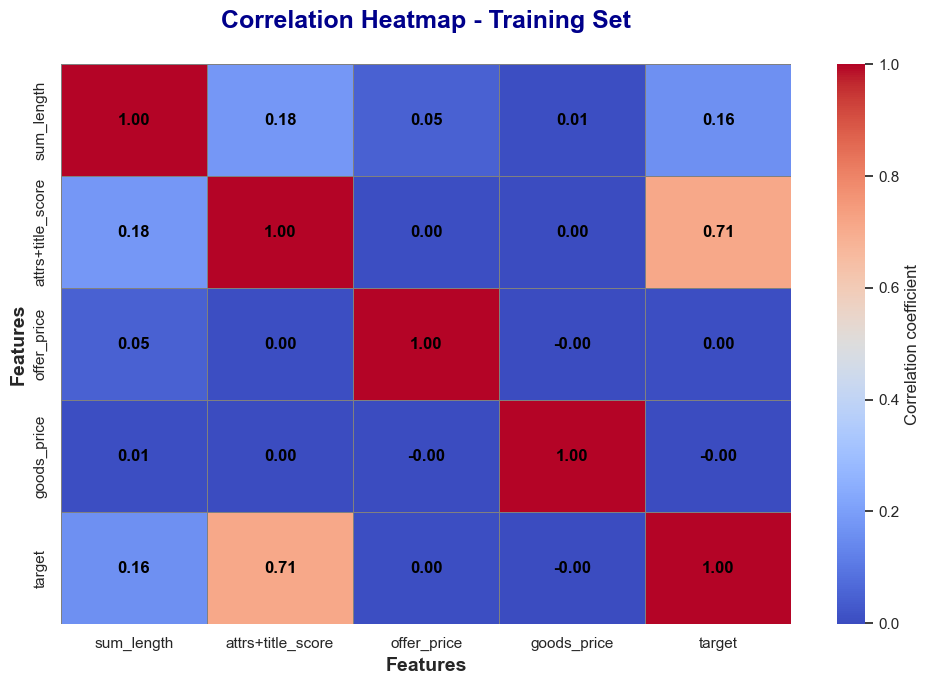

In [23]:
plt.figure(figsize=(10, 7))
plt.title('Correlation Heatmap - Training Set', fontsize=18, y=1.05, color='darkblue', fontweight='bold')
sns.heatmap(train_dataset.drop(['id', 'goods_category_id', 'goods_depersanalised', 'offer_depersanalised'], axis=1).corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'},  
            cbar_kws={'label': 'Correlation coefficient'},  
            linewidths=0.5,  
            linecolor='gray')  

plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')

plt.tight_layout()  
plt.show()

#### `test_dataset`

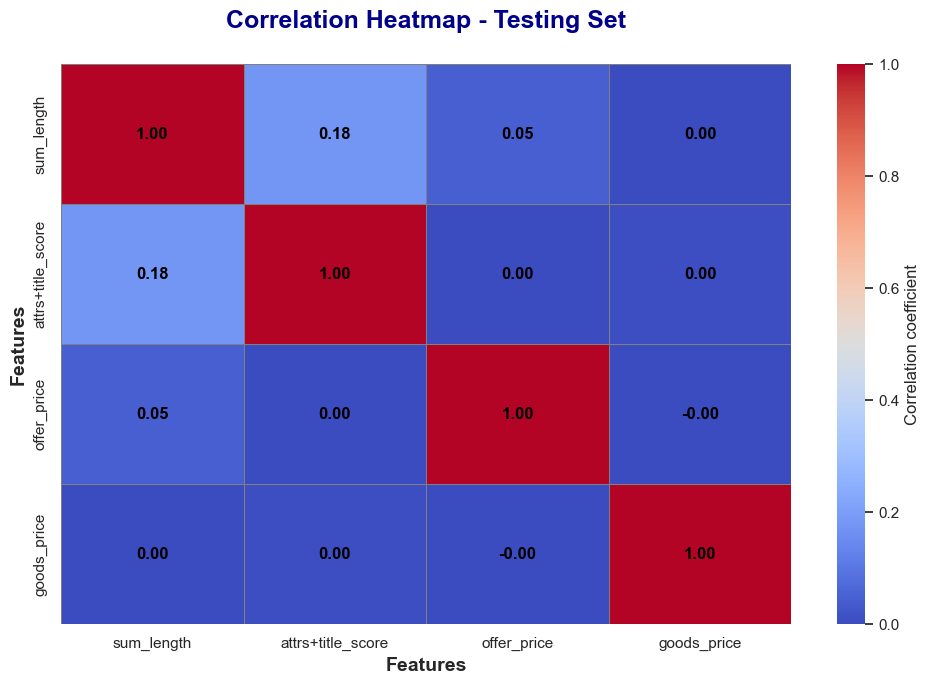

In [24]:
plt.figure(figsize=(10, 7))
plt.title('Correlation Heatmap - Testing Set', fontsize=18, y=1.05, color='darkblue', fontweight='bold')
sns.heatmap(test_dataset.drop(['id', 'goods_category_id', 'goods_depersanalised', 'offer_depersanalised'], axis=1).corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'},  
            cbar_kws={'label': 'Correlation coefficient'},  
            linewidths=0.5,  
            linecolor='gray')  

plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')

plt.tight_layout()  
plt.show()

The correlation analysis demonstrates that the only notable relationship exists between the `target` and the `attrs+title_score` feature in the `train_dataset`. However, while this correlation is stronger compared to other features, it is not sufficiently robust to warrant any immediate elimination of other features from the dataset. As such, all features will be retained to ensure the preservation of potential predictive information that may enhance the model’s performance during training and validation phases.

### Data Transformation (Normalization and One-Hot Encoding)

Before proceeding with ML model training, it is essential to ensure that the dataset is properly preprocessed to optimize the model's performance and generalization. This involves addressing two key aspects of feature representation: **scaling numerical features** and **encoding categorical features**.

- **Normalization of Numerical Features:**
    - Numerical features, such as `sum_length`, `attrs+title_score`, `offer_price`, and `goods_price`, can have varying ranges and magnitudes. Differences in scale can negatively impact the model, especially algorithms that rely on distance metrics (gradient descent-based models or k-nearest neighbors).

    - To standardize these features, the dataset will be normalized using **StandardScaler**, which transforms the data to have a mean of 0 and a standard deviation of 1. This ensures that all numerical features contribute equally to the model and prevents dominant features from overshadowing others during training.
    
- **One-Hot Encoding of Categorical Features:**

    - Categorical variables, such as `goods_category_id`, are discrete in nature and cannot be directly interpreted by most machine learning models. Encoding them into numerical representations is necessary for computational processing.

    - One-hot encoding will be used to represent each category as a binary feature, preserving the information of distinct categories while avoiding ordinality issues. Additionally, the first category will be dropped to prevent multicollinearity, and rare or unknown categories will be handled appropriately using the encoder's functionality.

By implementing these transformations:

- The numerical features will be standardized, improving the model's stability and convergence during training.

- The categorical features will be converted into a format suitable for machine learning models, ensuring that the data is both interpretable and robust.

In [31]:
# function to normalize
def normalize_features(dataset, features_to_scale):
    """
    Normalizes specified features in the dataset using StandardScaler.
    
    Parameters:
        dataset (DataFrame)
        features_to_scale (list)
    
    Returns:
        DataFrame
        scaler
    """
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the dataset
    scaler.fit(dataset[features_to_scale])
    scaled_feature_names = scaler.get_feature_names_out()
    
    # Replace original columns with scaled values
    dataset[features_to_scale] = pd.DataFrame(
        scaler.transform(dataset[features_to_scale]), 
        columns=scaled_feature_names
    )
    
    return dataset, scaler

# function to one-hot-encode
def one_hot_encode(dataset, features_to_encode):
    """
    One-hot encodes specified categorical features in the dataset using OneHotEncoder.
    
    Parameters:
        dataset (DataFrame)
        features_to_encode (list)
    
    Returns:
        DataFrame
        list
    """
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
    
    # Fit and transform the dataset
    ohe.fit(dataset[features_to_encode])
    feature_names = ohe.get_feature_names_out()
    
    # Create a DataFrame with encoded features
    encoded_features = pd.DataFrame(
        ohe.transform(dataset[features_to_encode]),
        columns=feature_names
    )
    
    # Reset indices to match and merge with the dataset
    dataset = dataset.drop(features_to_encode, axis=1).reset_index(drop=True)
    encoded_features = encoded_features.reset_index(drop=True)
    dataset = dataset.join(encoded_features, how='outer')
    
    return dataset, feature_names

In [32]:
to_scale = ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price']
to_encode = ['goods_category_id']

In [37]:
train_dataset = one_hot_encode(normalize_features(train_dataset, to_scale), to_encode)[0]
test_dataset = one_hot_encode(normalize_features(test_dataset, to_scale), to_encode)[0]

In [38]:
display(train_dataset.head(2))
display(test_dataset.head(2))

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,target,id,goods_category_id_3.0,goods_category_id_4.0,...,goods_category_id_17.0,goods_category_id_18.0,goods_category_id_19.0,goods_category_id_21.0,goods_category_id_69.0,goods_category_id_81.0,goods_category_id_82.0,goods_category_id_83.0,goods_category_id_99.0,goods_category_id_2463684633817211.0
0,295140,1396793,-1.289479,-0.383736,-0.097729,-0.005516,0,295140$1396793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65291,1396586,-1.287134,-0.296211,-0.097767,-0.005516,0,65291$1396586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,id,goods_category_id_3.0,goods_category_id_4.0,goods_category_id_5.0,...,goods_category_id_17.0,goods_category_id_18.0,goods_category_id_19.0,goods_category_id_21.0,goods_category_id_69.0,goods_category_id_81.0,goods_category_id_82.0,goods_category_id_83.0,goods_category_id_99.0,goods_category_id_2463684633817211.0
0,64819,1396468,-1.286773,-0.306923,-0.098931,-0.004799,64819$1396468,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64819,1396235,-1.286773,-0.306923,-0.098931,-0.004799,64819$1396235,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Conclusion: Data Preprocessing

- Both `train_dataset` and `test_dataset` underwent thorough preprocessing to address missing values and duplicate entries, ensuring data integrity for modeling tasks.
- **Missing values**:
  - **`goods_category_id`**: Missing values were replaced with a placeholder value of `99` to preserve existing categories and avoid bias. This placeholder will be treated as a distinct category during one-hot encoding.
  - **`goods_price`**: Missing values were imputed using **category-specific medians**, ensuring consistency within each category while maintaining robustness against outliers.
- **Duplicate entries**:
  - The **training dataset** contained duplicates based on columns like `goods_depersanalised`, `offer_depersanalised`, and `id`. These duplicates likely reflect legitimate business logic, such as variations in offers or pricing. They were retained as they provide valuable insights for modeling.
  - The **test dataset** was confirmed to be free of duplicates, ensuring clean and reliable data for evaluation.
- **Correlation analysis**:
  - The analysis indicates that the only notable relationship exists between the `target` and the `attrs+title_score` feature in the training dataset. While this correlation is stronger compared to other features, it is not robust enough to justify the elimination of any features. Thus, all features will be retained to ensure the preservation of potential predictive information that may enhance the model's performance during training and validation phases.
- **Normalization of numerical features**:
  - Features such as `sum_length`, `attrs+title_score`, `offer_price`, and `goods_price` were normalized using **StandardScaler** to ensure they are on a similar scale, improving model performance and convergence during training.
- **One-hot encoding of categorical features**:
  - The `goods_category_id` column was one-hot encoded to represent its categories as binary features. This encoding ensures that the model can effectively interpret categorical data without introducing unnecessary bias.

By implementing these preprocessing steps, the datasets are now **well-structured**, **optimized**, and ready for robust machine learning modeling and analysis.


# Image and Text Embeddings

## Load Data

In [42]:
# paths definition

image_goods_embed_path = os.getenv('IMAGE_GOODS_EMBED_PATH')
image_goods_items_path = os.getenv('IMAGE_GOODS_ITEMS_PATH')

title_goods_embed_path = os.getenv('TITLE_GOODS_EMBED_PATH')
title_goods_items_path = os.getenv('TITLE_GOODS_ITEMS_PATH')

image_offer_embed_path = os.getenv('IMAGE_OFFER_EMBED_PATH')
image_offer_items_path = os.getenv('IMAGE_OFFER_ITEMS_PATH')

title_offer_embed_path = os.getenv('TITLE_OFFER_EMBED_PATH')
title_offer_items_path = os.getenv('TITLE_OFFER_ITEMS_PATH')

# data load

# goods images
goods_image_embed = np.load(image_goods_embed_path)
goods_image_items = np.load(image_goods_items_path)

# goods titles
goods_title_embed = np.load(title_goods_embed_path)
goods_title_items = np.load(title_goods_items_path)

# offers images
offer_image_embed  = np.load(image_offer_embed_path)
offer_image_items = np.load(image_offer_items_path)

# offer titles
offer_title_embed  = np.load(title_offer_embed_path)
offer_title_items  = np.load(title_offer_items_path)

## Embeddings Shape Overview

In [47]:
print('Dimension of IMAGE embeddings for GOODS', goods_image_embed.shape)
print(f'Amount of IMAGE embeddings for GOODS {goods_image_items.shape}\n')

print('Dimension of TITLE embeddings for GOODS', goods_title_embed.shape)
print(f'Amount of TITLE embeddings for GOODS {goods_title_items.shape}\n')

print('Dimension of IMAGE embeddings for OFFER', offer_image_embed.shape)
print(f'Amount of IMAGE embendings for OFFER {offer_image_items.shape}\n')

print('Dimension of TITLE embeddings for OFFER', offer_title_embed.shape)
print('Amount of TITLE embeddings for OFFER', offer_title_items.shape)

Dimension of IMAGE embeddings for GOODS (317707, 256)
Amount of IMAGE embeddings for GOODS (317707,)

Dimension of TITLE embeddings for GOODS (1760568, 64)
Amount of TITLE embeddings for GOODS (1760568,)

Dimension of IMAGE embeddings for OFFER (457586, 256)
Amount of IMAGE embendings for OFFER (457586,)

Dimension of TITLE embeddings for OFFER (572767, 64)
Amount of TITLE embeddings for OFFER (572767,)


**Key Outputs**

1. **GOODS**:
   - **IMAGE embeddings**: Shape `(317707, 256)`
     - Represents **317,707 samples**, each with a **256-dimensional embedding vector**.
   - **TITLE embeddings**: Shape `(1760586, 64)`
     - Represents **1,760,586 samples**, each with a **64-dimensional embedding vector**.

2. **OFFER**:
   - **IMAGE embeddings**: Shape `(457586, 256)`
     - Represents **457,586 samples**, each with a **256-dimensional embedding vector**.
   - **TITLE embeddings**: Shape `(572767, 64)`
     - Represents **572,767 samples**, each with a **64-dimensional embedding vector**.

**Observations**

- **Dimensionality**:
  - **IMAGE embeddings** have higher dimensions (256) compared to **TITLE embeddings** (64). This suggests a richer feature representation for images, likely due to the complexity of visual data.
- **Sample counts**:
  - The number of samples varies significantly between `GOODS` and `OFFER`, indicating differences in dataset size or focus for these categories.

## Dimension Reduction

After examining the embeddings' structure and dimensions, it becomes evident that their current size could potentially introduce challenges such as high computational overhead and the risk of overfitting due to the curse of dimensionality. To address these issues and enhance the efficiency of the dataset for predictive modeling, dimensionality reduction will be applied. Specifically:

- **Reduction via PCA**:
  - Principal Component Analysis (PCA) is selected as the dimensionality reduction technique due to its ability to retain the maximum variance while projecting data to fewer dimensions.
  - Although **UMAP** is known to produce more accurate embeddings, it is computationally intensive and slower, making PCA a more practical choice for large datasets, where efficiency and speed are critical.

##### A function for dimension reducton

In [48]:
def reduce_and_merge(embeddings, ids, id_column, dataset, prefix, n_components=5):
    """
    Reduces the dimensionality of embeddings, renames the columns, and merges with the main dataset.

    Parameters:
        embeddings (ndarray): The embedding matrix to reduce.
        ids (ndarray): The corresponding IDs for the embeddings.
        id_column (str): The name of the ID column.
        dataset (DataFrame): The main dataset to merge with.
        prefix (str): Prefix for the new column names.
        n_components (int): Number of components for PCA.

    Returns:
        DataFrame: Updated dataset with reduced embeddings merged.
    """
    # Apply PCA
    reducer = PCA(n_components=n_components, random_state=42)
    reduced_embeddings = pd.DataFrame(reducer.fit_transform(embeddings))
    reduced_df = pd.DataFrame(ids, columns=[id_column]).join(reduced_embeddings)
    reduced_df[id_column] = reduced_df[id_column].astype('int32')
    reduced_df.columns = [id_column] + [f"{prefix}_{i}" for i in range(1, n_components + 1)]
    # Drop duplicates
    reduced_df = reduced_df.drop_duplicates(subset=id_column)
    # Merge with the main dataset
    dataset = dataset.merge(reduced_df, how='left', on=id_column)

    return dataset

##### Application of the function to each dataset

In [49]:
# GOODS image embeddings
train_dataset = reduce_and_merge(
    embeddings=goods_image_embed,
    ids=goods_image_items,
    id_column='goods_depersanalised',
    dataset=train_dataset,
    prefix='goods_image',
    n_components=5
)
test_dataset = reduce_and_merge(
    embeddings=goods_image_embed,
    ids=goods_image_items,
    id_column='goods_depersanalised',
    dataset=test_dataset,
    prefix='goods_image',
    n_components=5
)

# GOODS title embeddings
train_dataset = reduce_and_merge(
    embeddings=goods_title_embed,
    ids=goods_title_items,
    id_column='goods_depersanalised',
    dataset=train_dataset,
    prefix='goods_title',
    n_components=5
)
test_dataset = reduce_and_merge(
    embeddings=goods_title_embed,
    ids=goods_title_items,
    id_column='goods_depersanalised',
    dataset=test_dataset,
    prefix='goods_title',
    n_components=5
)

# OFFER image embeddings
train_dataset = reduce_and_merge(
    embeddings=offer_image_embed,
    ids=offer_image_items,
    id_column='offer_depersanalised',
    dataset=train_dataset,
    prefix='offer_image',
    n_components=5
)
test_dataset = reduce_and_merge(
    embeddings=offer_image_embed,
    ids=offer_image_items,
    id_column='offer_depersanalised',
    dataset=test_dataset,
    prefix='offer_image',
    n_components=5
)

# OFFER title embeddings
train_dataset = reduce_and_merge(
    embeddings=offer_title_embed,
    ids=offer_title_items,
    id_column='offer_depersanalised',
    dataset=train_dataset,
    prefix='offer_title',
    n_components=5
)
test_dataset = reduce_and_merge(
    embeddings=offer_title_embed,
    ids=offer_title_items,
    id_column='offer_depersanalised',
    dataset=test_dataset,
    prefix='offer_title',
    n_components=5
)

##### Resulting `train_dataset` and `test_dataset`:

In [52]:
display(train_dataset.info())
display(test_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 48 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   offer_depersanalised                  int64  
 1   goods_depersanalised                  int64  
 2   sum_length                            float64
 3   attrs+title_score                     float64
 4   offer_price                           float64
 5   goods_price                           float64
 6   target                                int64  
 7   id                                    object 
 8   goods_category_id_3.0                 float64
 9   goods_category_id_4.0                 float64
 10  goods_category_id_5.0                 float64
 11  goods_category_id_6.0                 float64
 12  goods_category_id_7.0                 float64
 13  goods_category_id_8.0                 float64
 14  goods_category_id_9.0                 float64
 15  goods_category_

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 47 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   offer_depersanalised                  363835 non-null  int64  
 1   goods_depersanalised                  363835 non-null  int64  
 2   sum_length                            363835 non-null  float64
 3   attrs+title_score                     363835 non-null  float64
 4   offer_price                           363835 non-null  float64
 5   goods_price                           363835 non-null  float64
 6   id                                    363835 non-null  object 
 7   goods_category_id_3.0                 363835 non-null  float64
 8   goods_category_id_4.0                 363835 non-null  float64
 9   goods_category_id_5.0                 363835 non-null  float64
 10  goods_category_id_6.0                 363835 non-null  float64
 11  

None

## Creating dictionaries to map IDs to their corresponding embeddings

In [53]:
def create_embedding_dict(ids, embeddings):
    """
    Creates a dictionary mapping IDs to embeddings.

    Parameters:
        ids (iterable): A list or array of IDs.
        embeddings (ndarray): A matrix of embeddings corresponding to the IDs.

    Returns:
        dict: A dictionary where keys are IDs and values are embeddings.
    """
    return {int(k): v for k, v in zip(ids, embeddings)}

# GOODS embeddings
goods_id2image_embed = create_embedding_dict(goods_image_items, goods_image_embed)
goods_id2title_embed = create_embedding_dict(goods_title_items, goods_title_embed)

# OFFER embeddings
offer_id2image_embed = create_embedding_dict(offer_image_items, offer_image_embed)
offer_id2title_embed = create_embedding_dict(offer_title_items, offer_title_embed)

## Feature Engineering

The dimensionality of the embeddings is too high to be directly integrated into a ML model effectively. To address this, we will derive compact, representative features from the embeddings, reducing their complexity while preserving their most relevant information for downstream predictive tasks.

In [54]:
def compute_embedding_distances(dataset, offer_to_title, offer_to_image, goods_to_title, goods_to_image):
    """
    Computes various distances (cosine, L1, L2, Canberra) between offer and goods embeddings.

    Parameters:
        dataset (DataFrame): The dataset containing the IDs for offer and goods embeddings.
        offer_to_title (dict): Dictionary mapping offer IDs to title embeddings.
        offer_to_image (dict): Dictionary mapping offer IDs to image embeddings.
        goods_to_title (dict): Dictionary mapping goods IDs to title embeddings.
        goods_to_image (dict): Dictionary mapping goods IDs to image embeddings.

    Returns:
        DataFrame: A dataset containing the calculated distances as new columns.
    """
    # Lists to store computed distances
    img_cos, img_l1, img_l2, img_canb = [], [], [], []
    tit_cos, tit_l1, tit_l2, tit_canb = [], [], [], []

    # Iterate through the dataset to compute distances
    for offer_id, goods_id in tqdm(zip(dataset['offer_depersanalised'], dataset['goods_depersanalised'])):
        try:
            # Fetch embeddings
            offer_title_embed = offer_to_title[offer_id]
            offer_image_embed = offer_to_image[offer_id]
            goods_title_embed = goods_to_title[goods_id]
            goods_image_embed = goods_to_image[goods_id]

            # Compute distances for image embeddings
            images_cosine = np.inner(offer_image_embed, goods_image_embed)
            images_l2 = np.linalg.norm(offer_image_embed - goods_image_embed)
            images_l1 = np.linalg.norm(offer_image_embed - goods_image_embed, ord=1)
            images_canb = np.sum(np.abs(offer_image_embed - goods_image_embed) / (np.abs(offer_image_embed) + np.abs(goods_image_embed)))

            # Compute distances for title embeddings
            titles_cosine = np.inner(offer_title_embed, goods_title_embed)
            titles_l2 = np.linalg.norm(offer_title_embed - goods_title_embed)
            titles_l1 = np.linalg.norm(offer_title_embed - goods_title_embed, ord=1)
            titles_canb = np.sum(np.abs(offer_title_embed - goods_title_embed) / (np.abs(offer_title_embed) + np.abs(goods_title_embed)))

            # Append to respective lists
            img_cos.append(images_cosine)
            img_l1.append(images_l1)
            img_l2.append(images_l2)
            img_canb.append(images_canb)

            tit_cos.append(titles_cosine)
            tit_l1.append(titles_l1)
            tit_l2.append(titles_l2)
            tit_canb.append(titles_canb)

        except KeyError:
            # Handle missing embeddings
            img_cos.append(np.NaN)
            img_l1.append(np.NaN)
            img_l2.append(np.NaN)
            img_canb.append(np.NaN)

            tit_cos.append(np.NaN)
            tit_l1.append(np.NaN)
            tit_l2.append(np.NaN)
            tit_canb.append(np.NaN)

    # Add computed distances as new columns to the dataset
    dataset['img_cos'] = img_cos
    dataset['img_l1'] = img_l1
    dataset['img_l2'] = img_l2
    dataset['img_canb'] = img_canb

    dataset['tit_cos'] = tit_cos
    dataset['tit_l1'] = tit_l1
    dataset['tit_l2'] = tit_l2
    dataset['tit_canb'] = tit_canb

    return dataset


In [55]:
train_dataset = compute_embedding_distances(
    dataset=train_dataset,
    offer_to_title=offer_id2title_embed,
    offer_to_image=offer_id2image_embed,
    goods_to_title=goods_id2title_embed,
    goods_to_image=goods_id2image_embed
)

test_dataset = compute_embedding_distances(
    dataset=test_dataset,
    offer_to_title=offer_id2title_embed,
    offer_to_image=offer_id2image_embed,
    goods_to_title=goods_id2title_embed,
    goods_to_image=goods_id2image_embed
)

2518441it [01:52, 22424.42it/s]
363835it [00:06, 60095.72it/s]


In [56]:
def add_price_features(dataset):
    """
    Adds price difference features to the dataset.

    Parameters:
        dataset (DataFrame): The dataset containing 'offer_price' and 'goods_price' columns.

    Returns:
        DataFrame: The updated dataset with two new columns:
                  - 'price_abs_diff': Absolute difference between offer and goods prices.
                  - 'price_diff': Ratio of offer price to goods price.
    """
    dataset['price_abs_diff'] = dataset.apply(
        lambda row: abs(row['offer_price'] - row['goods_price']), axis=1
    )
    dataset['price_diff'] = dataset.apply(
        lambda row: row['offer_price'] / row['goods_price'] if row['goods_price'] != 0 else 9999, axis=1
    )
    return dataset

In [57]:
train_dataset = add_price_features(train_dataset)
test_dataset = add_price_features(test_dataset)

In [58]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 58 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   offer_depersanalised                  int64  
 1   goods_depersanalised                  int64  
 2   sum_length                            float64
 3   attrs+title_score                     float64
 4   offer_price                           float64
 5   goods_price                           float64
 6   target                                int64  
 7   id                                    object 
 8   goods_category_id_3.0                 float64
 9   goods_category_id_4.0                 float64
 10  goods_category_id_5.0                 float64
 11  goods_category_id_6.0                 float64
 12  goods_category_id_7.0                 float64
 13  goods_category_id_8.0                 float64
 14  goods_category_id_9.0                 float64
 15  goods_category_

# Model Evaluation

**LightGBM** was selected as the primary model for this project due to its alignment with the specific characteristics and requirements of the dataset and objectives. The decision is based on the following concrete points related to the project:

---

**1. Suitability for Structured Data**
- The dataset consists of structured/tabular data with both numerical features (`price_abs_diff`, `price_diff`, and embedding-based distance metrics like `img_cos`, `tit_l2`) and categorical features (`goods_category_id`).
- LightGBM is optimized for structured data tasks and consistently delivers high predictive performance in these scenarios.

**2. Handling Large-Scale Data**
- The project involves processing embeddings and calculating multiple derived features across millions of samples in both the `train_dataset` and `test_dataset`.
- LightGBM’s ability to scale efficiently makes it well-suited for managing large datasets without significant computational overhead.

**3. Integration with Feature Engineering**
- This project incorporates complex feature engineering steps, such as dimensionality reduction (via PCA), embedding-based distance metrics, and price comparison features. LightGBM can effectively utilize these diverse features, including high-dimensional data, without excessive tuning.
- Native handling of categorical features (`goods_category_id`) reduces preprocessing complexity and ensures seamless integration with the dataset.

**4. Computational Efficiency**
- Considering the need to efficiently process large datasets, **LightGBM**’s histogram-based learning technique ensures faster training compared to other gradient boosting frameworks (XGBoost). 
- When compared to **CatBoost**, LightGBM tends to be more computationally efficient in terms of training speed due to its simplified approach to categorical feature handling (CatBoost uses a specialized algorithm for categorical data that can increase training time). 
- LightGBM’s lower memory usage and faster processing times make it an optimal choice for projects where resource constraints and rapid experimentation are key priorities.
- While CatBoost excels in categorical feature handling and achieves slightly higher accuracy in certain scenarios, LightGBM strikes a better balance between speed and performance for datasets with complex numerical and embedding-based features like those in this project.

**5. Resilience to Imbalanced Data**
- The dataset may include imbalanced distributions across categories (`goods_category_id`). LightGBM’s parameters, such as `scale_pos_weight`, enable effective handling of imbalanced data, ensuring better generalization during model training.

**6. Robust Performance**
- The embedding-based features (cosine similarity, Euclidean distances) add complexity to the feature space. LightGBM is known for its robustness in capturing intricate relationships between features, making it ideal for leveraging the embedding-derived features in this project.
- Models based on LightGBM are less prone to overfitting, especially with appropriate regularization settings.

**7. Adaptability for Future Expansion**
- As the project evolves, LightGBM’s distributed training mode and scalability ensure that larger datasets or additional features (more embedding-derived metrics) can be incorporated without significant architectural changes.
- The flexibility in defining objectives, such as classification, regression, or ranking, aligns perfectly with the project’s predictive goals.

**Conclusion**
- Given the large scale, structured nature, and complexity of the dataset, combined with the advanced feature engineering involved (embedding-based distances, dimensionality reduction), **LightGBM** provides an optimal solution. Its computational efficiency, scalability, and robust performance make it the perfect choice for achieving high accuracy while maintaining resource efficiency in this project.


## Splitting `train_dataset` into Training and Validation Sets

To create training and validation datasets for training a ML model while preserving data balance and ensuring reproducibility.

In [59]:
train_x, valid_x, train_y, valid_y = train_test_split(
    train_dataset.drop(['offer_depersanalised', 'goods_depersanalised', 'target', 'id'], axis=1),
    train_dataset['target'],
    test_size=0.15,
    random_state=42
)

## LightGBM Model
The objective is to train a LightGBM model on the prepared training data, evaluate its performance, and visualize metrics and feature importance.

**Defining Functions**
- **plot_feature_importance**:

    - Visualizes the top features impacting the model's decision-making.

    - Helps identify which features are most predictive for further optimization.


- **train_lgbm**:

    - Trains the LightGBM model on training data, validates on validation data, and evaluates its performance using F1 score.

    - Returns the trained model, F1 score, and evaluation metrics for further use.

- **plot_logloss**:

    - Plots training and validation log loss over iterations to monitor model convergence.



In [90]:
def plot_feature_importance(model, feature_names, max_features=10):

    importance = model.feature_importances_
    sorted_indices = importance.argsort()[::-1][:max_features]

    top_features = [feature_names[i] for i in sorted_indices]
    top_importances = importance[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], top_importances[::-1], color='royalblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()
    

def train_lgbm(train_x, train_y, valid_x, valid_y, 
               n_estimators, 
               random_state=42, 
               eval_metric='logloss', 
               log_period=100):

    lgbm = LGBMClassifier(
        random_state=random_state,
        objective='binary',
        n_estimators=n_estimators
    )

    lgbm.fit(
        train_x, train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric=eval_metric,
        callbacks=[log_evaluation(period=log_period)]
    )
 
    lgbm_pred = lgbm.predict(valid_x)

    lgbm_error = f1_score(valid_y, lgbm_pred)

    evals_result = lgbm.evals_result_

    return lgbm, lgbm_error, evals_result


def plot_logloss(evals_result, 
                 figsize=(12, 8), 
                 metric='binary_logloss', 
                 training_label='Training Logloss', 
                 validation_label='Validation Logloss'):

    plt.figure(figsize=figsize)
    
    plt.plot(evals_result['training'][metric], label=training_label, color='blue', linestyle='-', linewidth=2)
    plt.plot(evals_result['valid_1'][metric], label=validation_label, color='orange', linestyle='--', linewidth=2)
    
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.xlabel('Iterations', fontsize=12, fontweight='bold')
    plt.ylabel('Logloss', fontsize=12, fontweight='bold')
    plt.title('Training and Validation Logloss Over Iterations', fontsize=14, fontweight='bold', color='darkblue')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True, borderpad=1)
    
    plt.tight_layout()
    
    plt.show()

In [98]:
%%time
model, f1, evals_result = train_lgbm(train_x, train_y, valid_x, valid_y, 1500)

[LightGBM] [Info] Number of positive: 250487, number of negative: 1890187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 2140674, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117013 -> initscore=-2.021024
[LightGBM] [Info] Start training from score -2.021024
[100]	training's binary_logloss: 0.0528451	valid_1's binary_logloss: 0.0562931
[200]	training's binary_logloss: 0.0620211	valid_1's binary_logloss: 0.0658418
[300]	training's binary_logloss: 0.0544367	valid_1's binary_logloss: 0.0555653
[400]	training's binary_logloss: 0.0549808	valid_1's binary_logloss: 0.0565412
[500]	training's binary_logloss: 0.0542832	valid_1's binary_logloss: 0.0604819
[600]	training's binary_logloss: 0.0545574

In [99]:
print(f"F1: {f1}")

F1: 0.9193068055692919


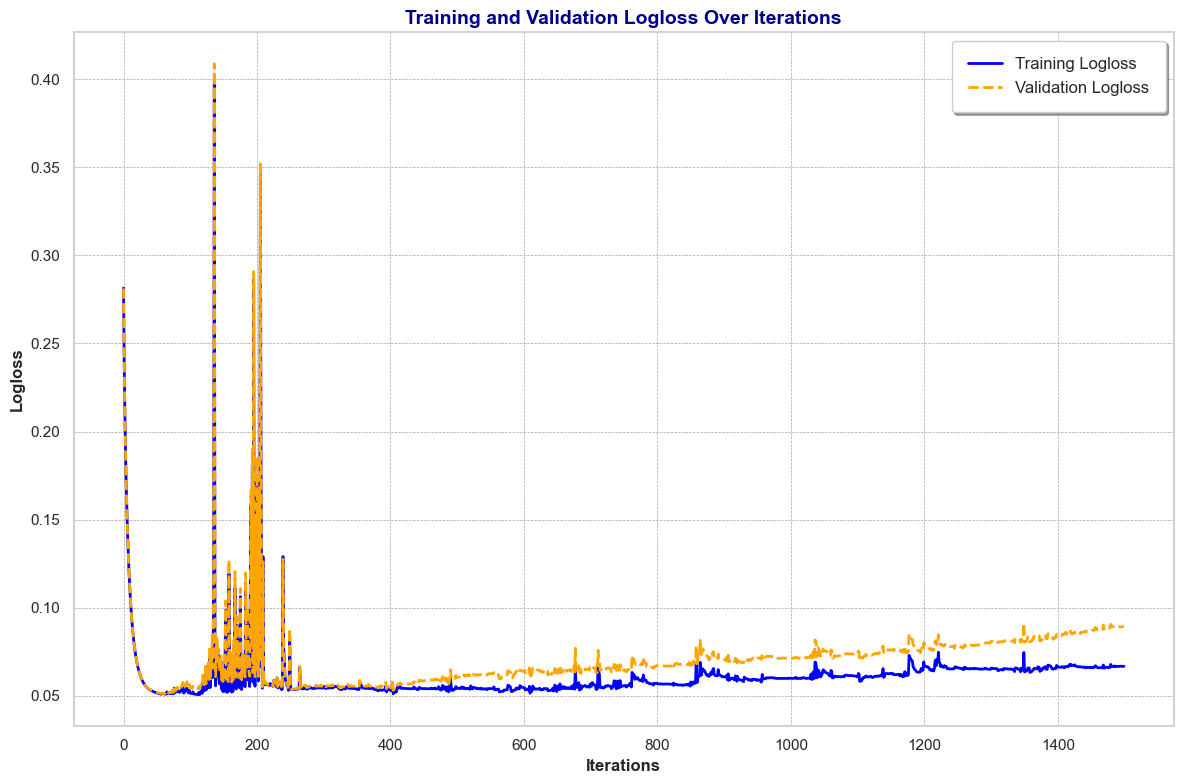

In [100]:
plot_logloss(evals_result)

The training loss reaches its minimum at approximately 300-400 iterations. Beyond this point, a trend of overfitting is observed as the loss begins to increase. Therefore, the number of boosting iterations will be set to 300 to optimize the F1 score while reducing computational time and preventing model degradation.

In [101]:
%%time
model, f1, evals_result = train_lgbm(train_x, train_y, valid_x, valid_y, 300)

[LightGBM] [Info] Number of positive: 250487, number of negative: 1890187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 2140674, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117013 -> initscore=-2.021024
[LightGBM] [Info] Start training from score -2.021024
[100]	training's binary_logloss: 0.0528451	valid_1's binary_logloss: 0.0562931
[200]	training's binary_logloss: 0.0620211	valid_1's binary_logloss: 0.0658418
[300]	training's binary_logloss: 0.0544367	valid_1's binary_logloss: 0.0555653
CPU times: total: 3min 36s
Wall time: 1min 2s


In [102]:
print(f"F1: {f1}")

F1: 0.9205952341788114


- The **300-iteration** model not only has a slightly higher F1 score (0.9206) but also maintains better generalization based on the log loss, with faster training time **1 minute 2 seconds** vs **5 minutes 18 seconds**.

- The **1500-iteration** model achieves a very similar F1 score (0.9193), but the slight drop and the overfitting trend indicate that the model’s capacity to generalize has diminished after more training time.

Overall, the **300-iteration** model is not only more time-efficient but also provides slightly better performance in terms of the F1 score, confirming that fewer iterations, in this case, yield better results.

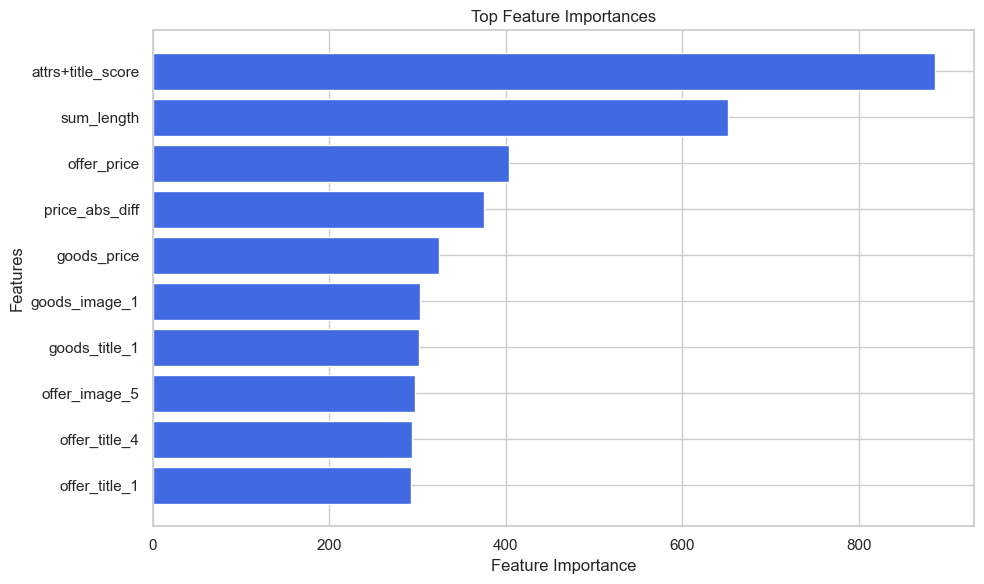

In [103]:
feature_names = train_x.columns.tolist()
plot_feature_importance(model, feature_names)

## Feature Importance Analysis 


**Top Features and Their Importance**

1. **`attrs+title_score`** (Importance ~900)
- The most influential feature in the model.
- Represents the alignment between product attributes and their titles.
- Strongly correlates with the target variable, making it a key factor in prediction.

2. **`sum_length`** (Importance ~600)
- The second most important feature, possibly derived from aggregated text length measures.
- Impacts predictions by reflecting descriptive quality or completeness.

3. **`offer_price`** (Importance ~400)
- Pricing information plays a critical role in prediction.
- Demonstrates the importance of monetary values in distinguishing between classes.

4. **`price_abs_diff`** (Importance ~300)
- The absolute difference between offer and goods price is a strong predictive indicator.
- Highlights the role of price disparities in shaping outcomes.

5. **`goods_price`** (Importance ~200)
- Reinforces the significance of pricing-related features.

---

**Visual Features**

6. **`goods_image_1`** (Importance ~150)
- Image-related feature demonstrates noticeable influence on prediction outcomes.
- Suggests that visual data contributes effectively to classification.

---

**Title-Based Features**

7. **`goods_title_1`, `offer_title_4`, and `offer_title_1`** (Importance ~100 each)
- Textual features in product and offer titles play a supporting yet impactful role in predictions.
- Indicates the importance of matching or contrasting keywords in titles.

---

**Key Insights**

**1. Pricing Dominance**
- Features related to pricing (`offer_price`, `goods_price`, `price_abs_diff`) collectively exhibit high importance.
- Pricing plays a substantial role in determining predictive outcomes.

**2. Textual Relevance**
- `attrs+title_score` and `sum_length` highlight the importance of textual similarity and descriptive completeness.

**3. Visual Contribution**
- Features like `goods_image_1` indicate that visual components are important, though less dominant compared to pricing and textual features.

**Recommendations**

**1. Enhance High-Importance Features**
- Optimize textual similarity features (`attrs+title_score`) for better predictive performance.
- Ensure data quality for pricing features (`offer_price`, `goods_price`, etc.).

**2. Leverage Visual Data**
- Improve representation quality for image features (e.g., preprocessing or embeddings) to maximize their predictive utility.

**3. Refine Less Influential Features**
- Evaluate lower-importance features to decide on elimination or transformation for model optimization.

**`test_dataset` predictions will be exported to test them in production**:

In [127]:
def predict_and_export(model, test_dataset, output_file):

    predictions = model.predict(test_dataset.drop(columns=['offer_depersanalised', 'goods_depersanalised', 'id'], axis=1)) 
    
    prediction_df = pd.DataFrame({
        'id': test_dataset['id'],  
        'predictions': predictions           
    })
    
    prediction_df.to_csv(output_file, index=False) 
    
    print(f"Predictions successfully saved to {output_file}")

In [128]:
predict_and_export(model, test_dataset=test_dataset, output_file="test_predictions.csv")

Predictions successfully saved to test_predictions.csv


In [129]:
test_predictions = pd.read_csv("test_predictions.csv")
test_predictions.sample(10)

,id,predictions
312261,251584$1487457,1
92846,93268$1220536,0
178704,86381$1025771,0
190655,214241$7692,0
240803,278274$1741856,0
28060,251808$1028642,0
296277,314229$242691,1
76304,56092$1185413,1
53487,126347$1236754,0
30711,31954$766583,0


## 🧾 Final Conclusion

This project successfully tackled a binary classification task by combining thorough data preprocessing, insightful exploratory analysis, and a robust modeling pipeline using LightGBM. Key highlights include:

- **Data Integrity**: Careful handling of missing values, duplicate detection, and structural data analysis ensured clean and reliable inputs for modeling.  
- **Data Preparation**: One-hot encoding and normalization techniques have been applied where appropriate. Tabular data has been successfully joined with text and image embeddings, enabling a more holistic representation of each observation.  
- **Feature Engineering**: Context-aware transformations, correlation analysis, and the creation of additional features contributed to improved data quality and model interpretability.  
- **Dimensionality Reduction**: Principal Component Analysis (PCA) has been applied to reduce feature dimensionality while preserving the most relevant variance in the data.  
- **Model Performance**: The LightGBM classifier demonstrated strong predictive power, achieving a high F1 score on validation data, supported by detailed evaluation metrics and feature importance visualization.  
- **Reproducibility & Clarity**: The workflow has been designed for clarity and maintainability, leveraging modular code structures and visualization tools to support interpretability and experimentation.  
- **ML Pipeline Readiness**: The components implemented—including preprocessing, feature engineering, dimensionality reduction, model training, and evaluation—are well-suited for integration into a production-level machine learning pipeline.  
- **Production Evaluation**: Predictions generated from the testing phase were later evaluated in a production environment, resulting in an F1 score of 0.92—demonstrating strong generalization and real-world applicability.

This work reflects a complete and technically sound approach to addressing a real-world classification problem using multimodal data.
